# Creating PFSS models from HMI synoptic maps

In [1]:
import drms

import matplotlib.pylab as plt

import numpy as np

import pandas as pd

import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits

from mpl_toolkits.mplot3d import Axes3D

import pfsspy
from pfsspy import coords
from pfsspy import tracing

import sunpy.map
from sunpy.visualization.colormaps import color_tables as ct
from sunpy.coordinates import frames

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.
(Register to download data from JSOC [here](http://jsoc.stanford.edu/ajax/register_email.html)).

In [2]:
email='your@email.address' # Put in a registered e-mail address

In [3]:
c = drms.Client(email=email, verbose=True)

Query one of two synoptic maps of the radial magnetic field. 

The [JSOC page on synoptic maps](http://jsoc.stanford.edu/HMI/LOS_Synoptic_charts.html) describes these data as follows:
 * `hmi.Synoptic_Mr_720s` provides the imputed radial component of the magnetic field over the entire solar disk. The maps are 3600 points in Carrington longitude by 1440 points equally spaced in sine latitude.
 * `hmi.mrsynop_small_720s` is the imputed radial component of the magnetic field over the entire solar disk. The maps are 720 points in Carrington longitude by 360 points equally spaced in sine latitude. This map is produced by applying a boxcar average to the high-resolution map, hmi.Synoptic_Mr_720s.

Query for some Carrington rotation numbers with isolated active regions that can easily be modelled with a PFSS. Carrington Rotation numbers for active regions observed on the [Sun Today page](http://suntoday.lmsal.com/suntoday/) or by looking through [HARP movies](http://jsoc.stanford.edu/data/hmi/HARPs_movies/definitive/) can be queried by using the `CAR_ROT` keyword in the `hmi.M_720s` series. In the example below, `out` returns a pandas data frame, where each column represents a keyword.

In [4]:
time = '2017.11.19_22:50:10'
hmi_query_string = 'hmi.M_720s['+time+'][? (QUALITY<65536) ?]' # The QUALITY filter ensures the data are of good quality
out = c.query(hmi_query_string, key=drms.const.all)

In [5]:
out['CAR_ROT']

0    2197
Name: CAR_ROT, dtype: int64

Here are some three good candidates. Good candidates are fairly isolated active regions (during that time period, and, ideally, within the entire Carrington Rotation).

| Carrington Rotation Number | NOAA Active Region Number | Date  | Links |
| -------------------------- | ------------------------- | ----- | ----- |
| Carrington Rotation 2197 | contains NOAA AR 12687 | which looks potential at 2017.11.19_22:50:10 | [[AIA]](http://suntoday.lmsal.com/sdomedia/SunInTime/2017/11/19/f0171pfss.jpg) [[HMI]](http://suntoday.lmsal.com/sdomedia/SunInTime/2017/11/19/f_HMImagpfss.jpg) |
| Carrington Rotation 2235 | contains NOAA AR 12773 | which looks potential at 2020.09.28_14:46:34 | [[AIA]](http://suntoday.lmsal.com/sdomedia/SunInTime/2020/09/28/f0171pfss.jpg) [[HMI]](http://suntoday.lmsal.com/sdomedia/SunInTime/2020/09/28/f_HMImagpfss.jpg) |
| Carrington Rotation 2236 | contains NOAA AR 12776 | which looks potential at 2020.10.20_21:44:58 | [[AIA]](http://suntoday.lmsal.com/sdomedia/SunInTime/2020/10/20/f0171pfss.jpg) [[HMI]](http://suntoday.lmsal.com/sdomedia/SunInTime/2020/10/20/f_HMImagpfss.jpg) |
| Carrington Rotation 2237 | contains NOAA AR 12782 | which looks potential at 2020.11.16_22:46:10 | [[AIA]](http://suntoday.lmsal.com/sdomedia/SunInTime/2020/11/16/f0171pfss.jpg) [[HMI]](http://suntoday.lmsal.com/sdomedia/SunInTime/2020/11/16/f_HMImagpfss.jpg) |

Query for Carrington rotation number 2237:

In [6]:
jsoc_request = c.export('hmi.synoptic_mr_polfil_720s[2237]{Mr_polfil}', protocol='fits')
image_url = jsoc_request.urls['url'][0]
print(image_url)
synoptic_image = fits.open(image_url)

Export request pending. [id=JSOC_20210507_1856_X_IN, status=2]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM66/D1399550206/S00000/hmi.synoptic_mr_polfil_720s.2237.Mr_polfil.fits


Fix header keywords using the same method in the [SunPy Example Gallery](https://docs.sunpy.org/en/stable/generated/gallery/plotting/hmi_synoptic_maps.html):

In [7]:
synoptic_image[1].header["CUNIT1"] = 'degree'
synoptic_image[1].header["CUNIT2"] = 'degree'
synoptic_image[1].header["CDELT1"] *= -1
synoptic_image[1].header["CDELT2"] = 180 / np.pi * synoptic_image[1].header["CDELT2"]

Delete FITS header keywords that do not conform to the FITS standard 😑

In [8]:
del synoptic_image[1].header["CRDER1"]
del synoptic_image[1].header["CRDER2"]
del synoptic_image[1].header["CSYSER1"]
del synoptic_image[1].header["CSYSER2"]

Add a keyword for `DATE_OBS` (which is the same as `T_OBS`), otherwise the SunPy map will populate the observation time with the current time

In [9]:
synoptic_image[1].header["DATE-OBS"] = synoptic_image[1].header["T_OBS"]

Count the number of NaNs

In [10]:
np.sum(~np.isfinite(synoptic_image[1].data))

0

Create a [SunPy Map object]()

In [11]:
synoptic_map = sunpy.map.Map(synoptic_image[1].data, synoptic_image[1].header)

Look at the data. For some reason the SunPy map is reading the wrong observation date, even though:

In [12]:
synoptic_map.fits_header['DATE-OBS']

'2020.11.14_23:01:43_TAI'

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,carrington
Wavelength,6173.0
Observation Date,2020-11-14 23:01:43
Exposure Time,0.000000 s
Dimension,[3600. 1440.] pix
Coordinate System,heliographic_carrington
Scale,[0.1 0.07957747] deg / pix
Reference Pixel,[1799. 719.5] pix

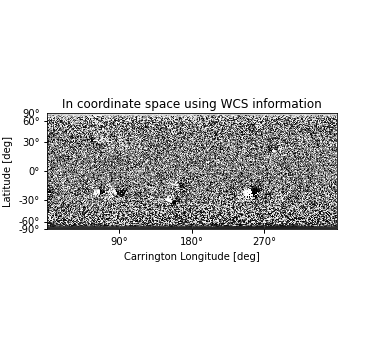
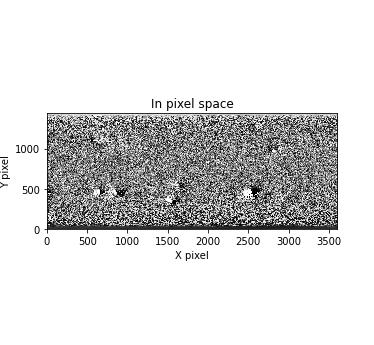
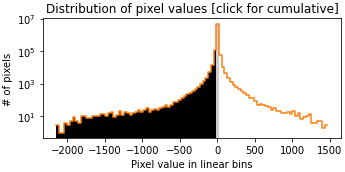
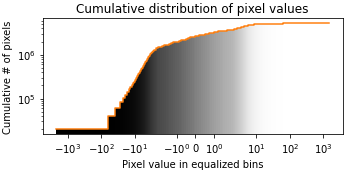

In [13]:
synoptic_map

The next step downsamples the map just to make the PFSS model run faster.

When not downsampling, expect increased runtimes.

In [14]:
new_dimensions = [360, 144] * u.pixel
synoptic_map_resampled = synoptic_map.resample(new_dimensions)

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,carrington
Wavelength,6173.0
Observation Date,2020-11-14 23:01:43
Exposure Time,0.000000 s
Dimension,[360. 144.] pix
Coordinate System,heliographic_carrington
Scale,[1. 0.79577472] deg / pix
Reference Pixel,[179.5 71.5] pix

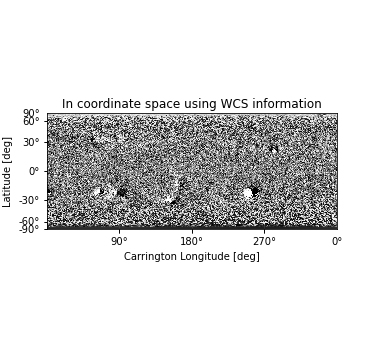
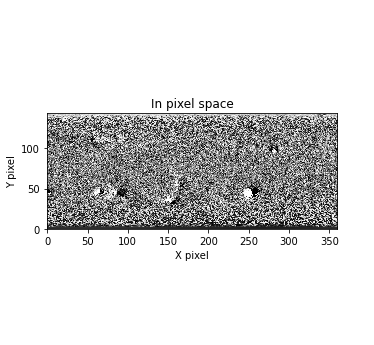
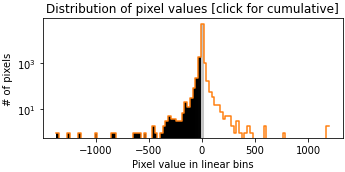
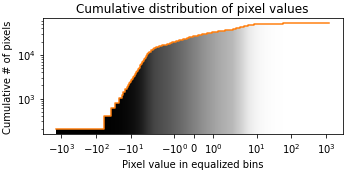

In [15]:
synoptic_map_resampled

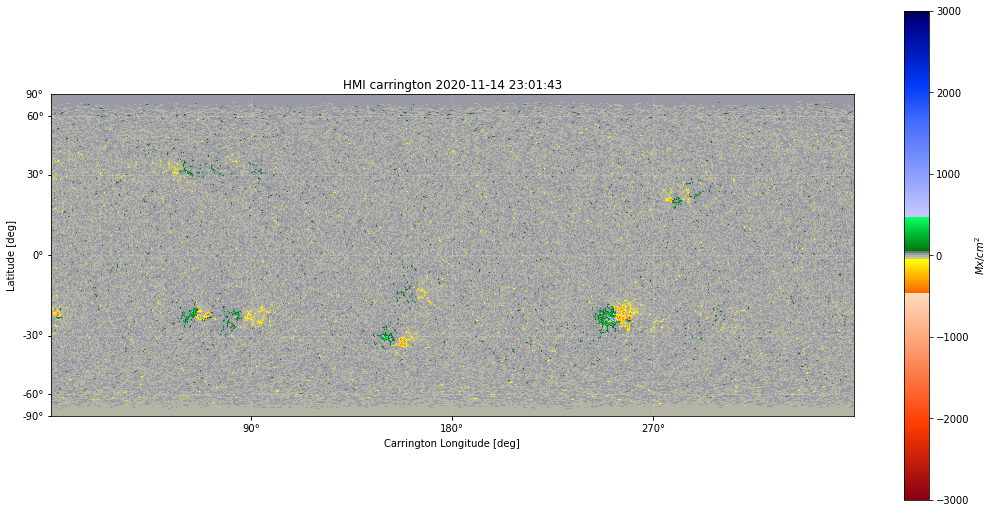

In [16]:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(projection=synoptic_map)
hmimag = plt.get_cmap('hmimag')
im = synoptic_map.plot(vmin=-3000, vmax=3000, cmap=hmimag)
cbar = plt.colorbar(im, label='${Mx}/{cm^2}$')

Generate the PFSS model

In [17]:
nrho = 35
rss = 2.5

In [18]:
input = pfsspy.Input(synoptic_map_resampled, nrho, rss)

Text(0.5, 1.0, 'Input field')

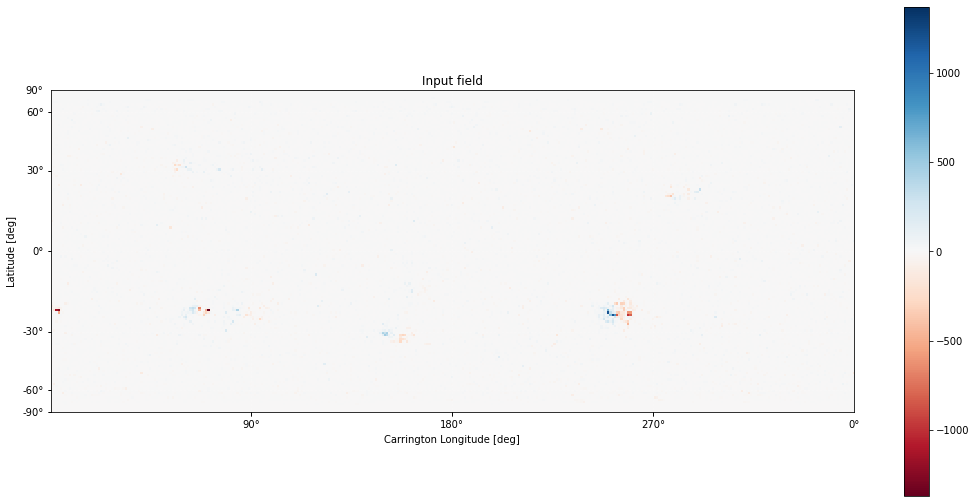

In [19]:
m = input.map
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()
ax.set_title('Input field')

In [20]:
output = pfsspy.pfss(input)

Plot the source surface field (taken from the [GONG PFSS example](https://pfsspy.readthedocs.io/en/stable/auto_examples/using_pfsspy/plot_gong.html)). The source surface PIL looks like a small blue dot (near -15 degrees latitude).

Text(0.5, 1.0, 'Source surface magnetic field')

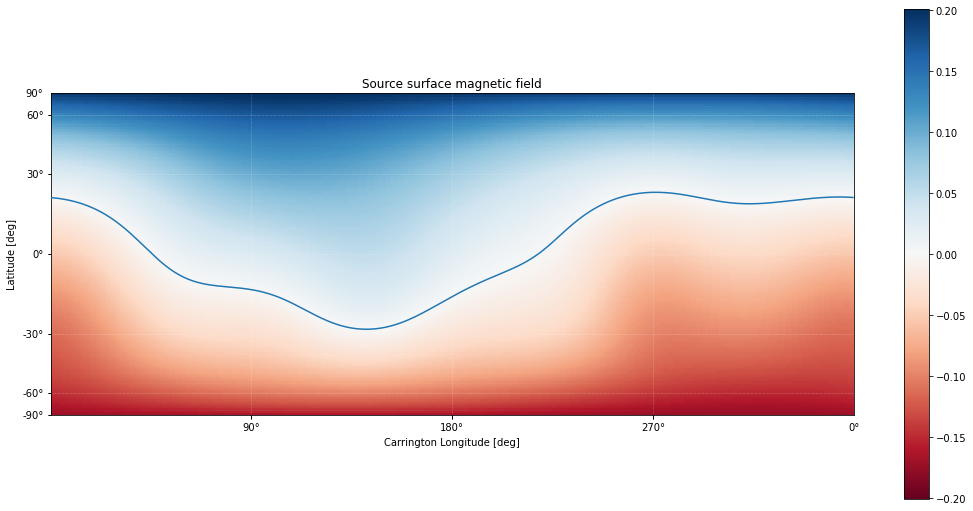

In [21]:
ss_br = output.source_surface_br
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=ss_br)
ss_br.plot()
ax.plot_coord(output.source_surface_pils[0])
plt.colorbar()
ax.set_title('Source surface magnetic field')

The PFSS model may identify one or many polarity inversion lines; most are near the poles

In [22]:
len(output.source_surface_pils)

1

The following lines are modified from the [overplotting field lines on AIA maps](https://pfsspy.readthedocs.io/en/stable/auto_examples/using_pfsspy/plot_aia_overplotting.html) example in the PFSSpy example gallery.

First, download the AIA data for the same `T_OBS` as the Synoptic Map:

In [23]:
synoptic_map_resampled.date

<Time object: scale='tai' format='isot' value=2020-11-14T23:01:43.000>

In [24]:
jsoc_request = c.export('aia.lev1[2020-11-14T23:01:43/12s][? WAVELNTH = 171 ?]{image_lev1}', protocol='fits')
aia_image_url = jsoc_request.urls['url'][0]
aia = sunpy.map.Map(aia_image_url)

Export request pending. [id=JSOC_20210507_2275, status=2]
Waiting for 5 seconds...


Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2020-11-14 23:01:45
Exposure Time,1.999560 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.59948897 0.59948897] arcsec / pix
Reference Pixel,[2054.88134766 2046.75585938] pix

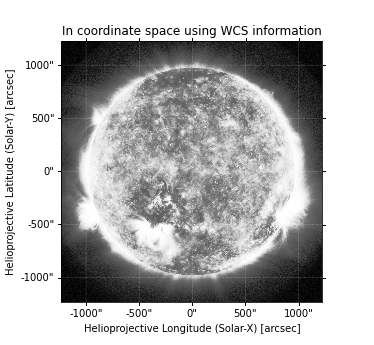
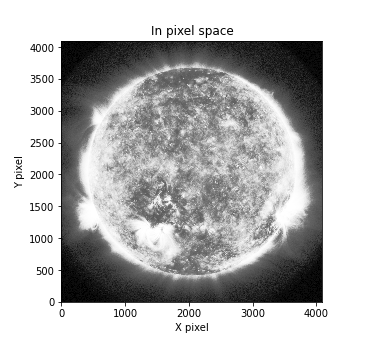
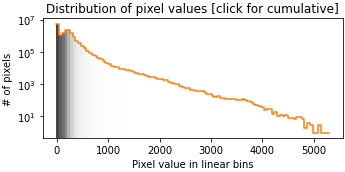
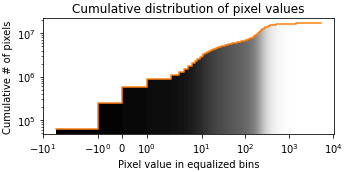

In [25]:
aia

Plot AIA image in Carrington Longitude and Latitude to identify footpoints of interest

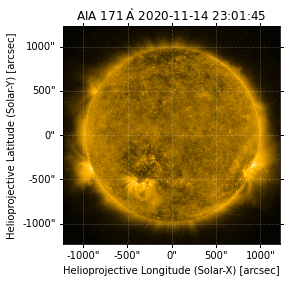

In [26]:
aia.plot()

Pick out a region of interest

In [27]:
aia_bottom_left = SkyCoord(-600 * u.arcsec,
                           -800 * u.arcsec,
                           frame=aia.coordinate_frame)
aia_top_right = SkyCoord(-100 * u.arcsec,
                         -400 * u.arcsec,
                         frame=aia.coordinate_frame)

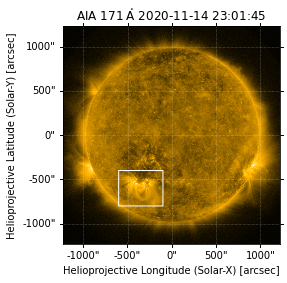

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=aia)
aia.plot(axes=ax)
aia.draw_rectangle(aia_bottom_left, top_right=aia_top_right)

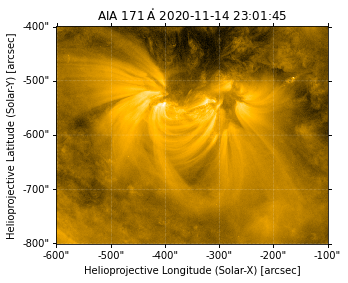

In [29]:
subaia = aia.submap(aia_bottom_left, top_right=aia_top_right)
fig = plt.figure()
subaia.plot()

Looking at the synoptic map below, this is the faint active region in the middle of the map. It looks like it goes from 135 to 170 degrees in Carrington Longitude and -20 to -45 degrees in Latitude.

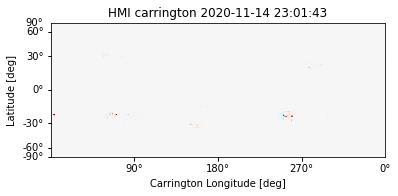

In [30]:
input.map.plot()

Use these carrington latitude and latitude values for `s` and `phi` below

Text(0.5, 1.0, 'Field line footpoints')

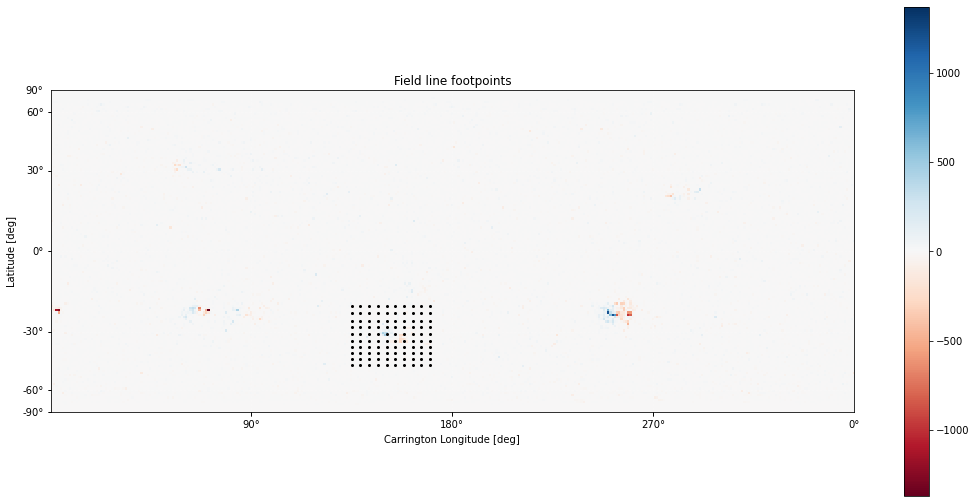

In [31]:
# Create 10 points spaced in latitude
s = np.linspace(-20, -45, 10)

# Create 10 points spaced in longitude
phi = np.linspace(135, 170, 10)

# Make a 2D grid from these points
s, phi = np.meshgrid(s, phi)

#Now convert the points to a coordinate object
lat = s * u.deg
lon = phi * u.deg
seeds = SkyCoord(lon.ravel(), lat.ravel(), 1.01 * const.R_sun,
                  frame=synoptic_map_resampled.coordinate_frame)

#Plot the seeds, which show the footpoints of the magnetic field lines
m = input.map
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)
ax.set_title('Field line footpoints')

Map selected field lines on input photospheric magnetic field

Text(0.5, 1.0, 'Photospheric field and traced field lines')

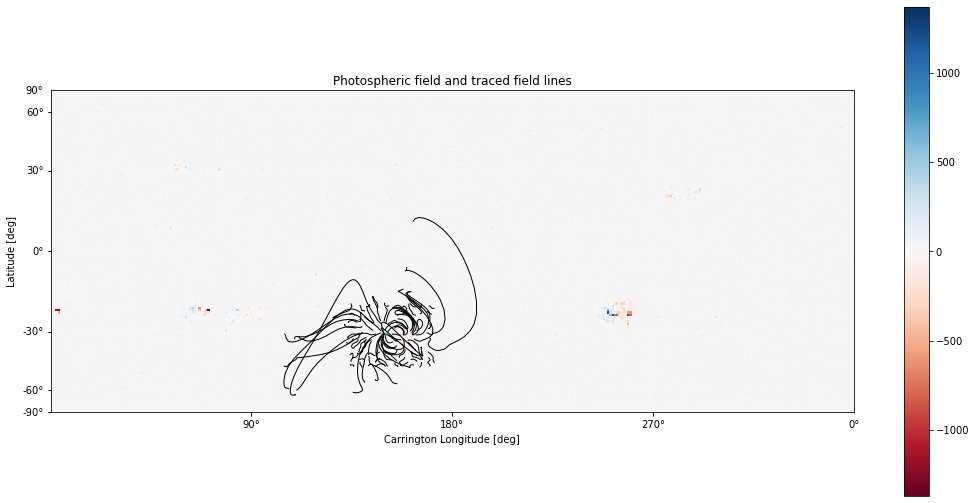

In [32]:
m = input.map
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()

tracer = tracing.PythonTracer()
field_lines = tracer.trace(seeds, output)

for field_line in field_lines:
    ax.plot_coord(field_line.coords, color='black', linewidth=1)

ax.set_title('Photospheric field and traced field lines')

Map selected field lines on AIA image

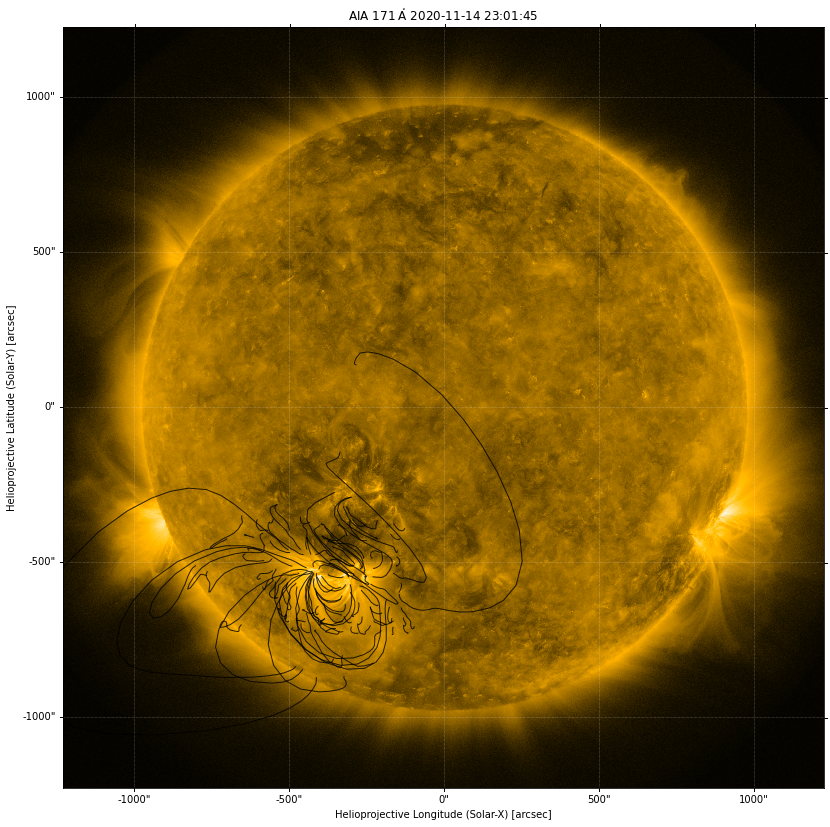

In [33]:
fig = plt.figure(figsize=(14,14))
ax = plt.subplot(1, 1, 1, projection=aia)
aia.plot(ax)

for field_line in field_lines:
    ax.plot_coord(field_line.coords, alpha=0.8, linewidth=1, color='black')

ax.set_xlim(0, 4096)
ax.set_ylim(0, 4096)
plt.show()